# Image classification with CNN

- 25000 labeled dog & cat photos for training
- 12500 test set

In [2]:
# automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# main external libs
from fastai.imports import *

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [5]:
# path to data
PATH = "data/dogscats/"
# resize target
sz = 224

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.backends.cudnn.enabled

True

## First look at cat pics

- assuming we have _train_ and _valid_ directories with subdirectories for classes

In [8]:
os.listdir(PATH)

['sample', 'valid', 'models', 'train', 'tmp', 'test1']

In [9]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [10]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.11341.jpg',
 'cat.3869.jpg',
 'cat.5089.jpg',
 'cat.7380.jpg',
 'cat.11409.jpg']

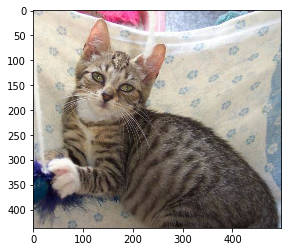

In [11]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [12]:
img.shape

(437, 499, 3)

In [13]:
img[:4,:4]

array([[[211, 212, 217],
        [210, 211, 216],
        [208, 207, 212],
        [202, 202, 204]],

       [[200, 201, 206],
        [198, 199, 203],
        [196, 195, 200],
        [193, 193, 195]],

       [[193, 192, 197],
        [189, 189, 191],
        [185, 183, 186],
        [186, 184, 187]],

       [[197, 195, 196],
        [189, 187, 188],
        [181, 179, 180],
        [183, 181, 182]]], dtype=uint8)

## First quick model

- using a pre-trained model resnet34, trained on imagenet

In [14]:
# if we need to reset precomputed weights
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       0.05038  0.02777  0.98975]                         
[ 1.       0.03908  0.02738  0.98926]                         



After 2 epochs we're already at 99.02% accuracy. Let's examine the results. It is often useful to look at specific examples of each of the following:

1. correctly labeled
2. incorrectly labeled
3. most correct labels of each class (ie highest probability that are correct)
4. most incorrect labels of each class (ie highest probability that are incorrect)
5. most uncertain labels (ie those with probability closest to 0.5)

In [15]:
# label for a val data
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [16]:
# cats is label 0, dogs is label 1
data.classes

['cats', 'dogs']

In [17]:
# gives prediction for validation set; predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [18]:
log_preds[:10]

array([[ -0.00003, -10.38869],
       [ -0.00117,  -6.75179],
       [ -0.0016 ,  -6.43975],
       [ -0.0002 ,  -8.5107 ],
       [ -0.00002, -10.98139],
       [ -0.00039,  -7.84295],
       [ -0.00005,  -9.92763],
       [ -0.00003, -10.49062],
       [ -0.00128,  -6.66401],
       [ -0.00009,  -9.33386]], dtype=float32)

In [19]:
preds = np.argmax(log_preds, axis=1) # from log prob to 0 or 1
probs = np.exp(log_preds[:,1]) # pr(dog)

In [20]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y) == is_correct)

In [21]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [22]:
def plots(imgs, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(imgs[i])

In [23]:
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH + ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


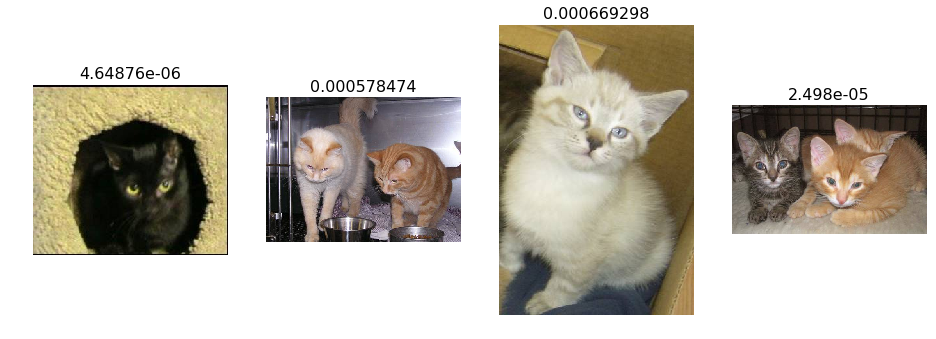

In [24]:
# correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


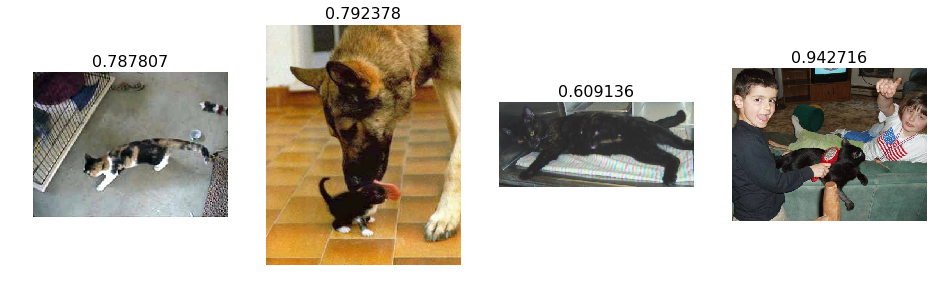

In [25]:
# incorrectly labeled at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [26]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if (y == 1) == is_correct else 1
    return most_by_mask(((preds == data.val_y) == is_correct) & (data.val_y == y), mult)

Most correct cats


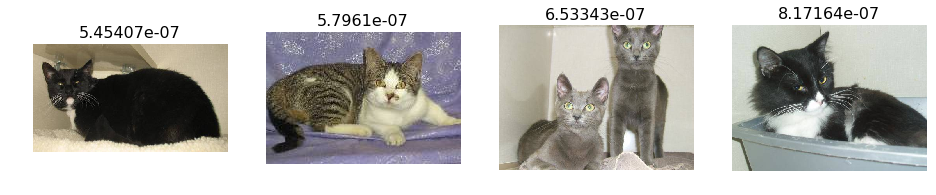

In [27]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


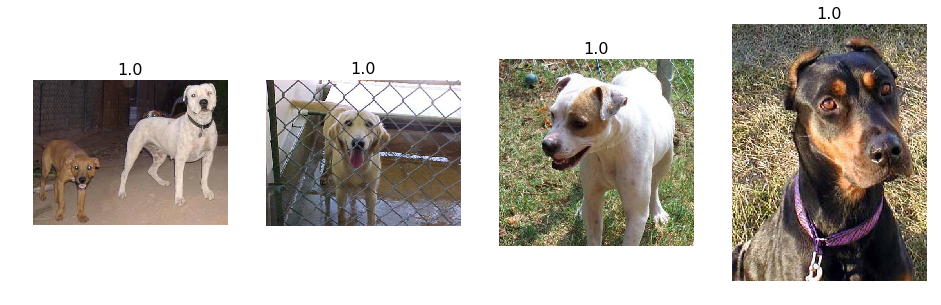

In [28]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


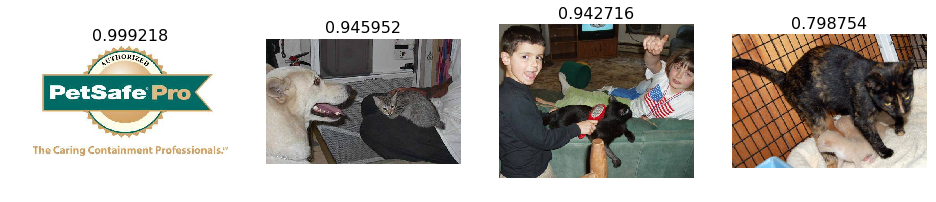

In [29]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


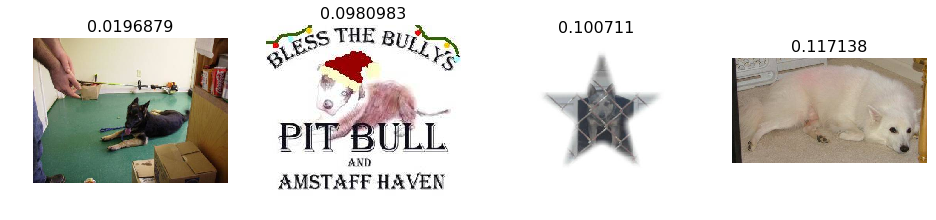

In [30]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


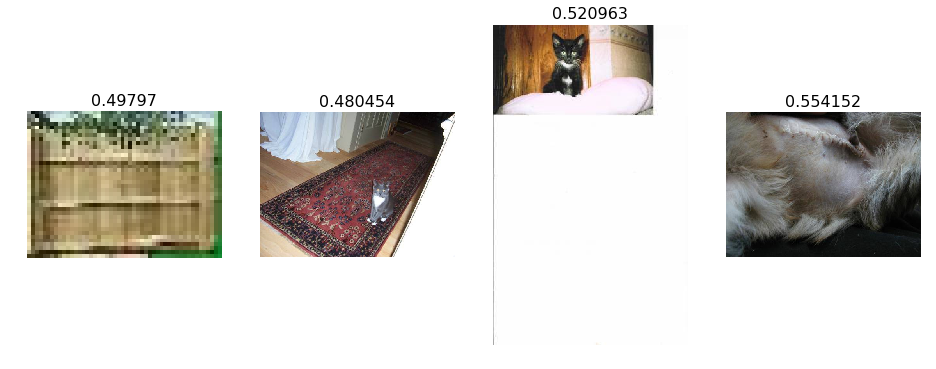

In [31]:
most_uncertain = np.argsort(np.abs(probs - 0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

- learning rate determines how quickly or slowly the weights are updated
- learn.lr_find() helps find an optimal learning rate by increasing the learning rate from a very small value until the loss stops decreasing

first we create a new learner since we want to know how to set the learning rate for a new (untrained) model

In [32]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 77%|███████▋  | 276/360 [00:04<00:01, 57.16it/s, loss=0.484]


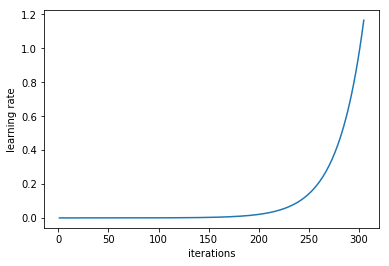

In [33]:
# sched contains learning rate scheduler
learn.sched.plot_lr()

- iteration is one minibatch of SGD
- each epoch has (num_train_samples / num_iterations) of SGD

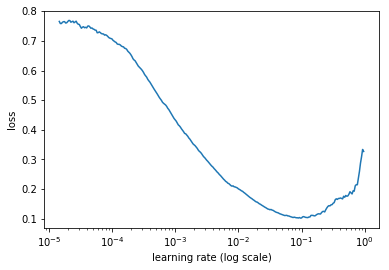

In [34]:
learn.sched.plot()

loss is still improving at lr=1e-2 (0.01), so that's what we use. note optimal learning rate can change as we train the model, so you may want to re-run from time to time.

## Improving our model

### Data augmentation

we will start to overfit if we continue to train this for more epochs, so ideally we would add more data. this can be achieved with _data augmentation_ by randomly changing images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, or rotating.

In [35]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [36]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x, _ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [37]:
ims = np.stack([get_augs() for i in range(6)])

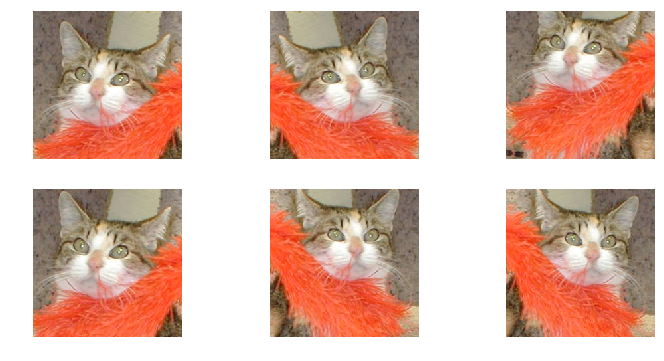

In [38]:
plots(ims, rows=2)

let's create a new data object that includes this augmentation in the transforms

In [39]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [40]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.04514  0.02911  0.9917 ]                         



In [41]:
learn.precompute=False

by default, when we create a learner, it sets all but the last layer to _frozen_. that means that it's still only updating the weights in the last layer when we call fit.

In [42]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.04314  0.02833  0.98779]                         
[ 1.       0.04033  0.02506  0.98975]                         
[ 2.       0.04983  0.02439  0.99072]                         



we've used a technique called _stochastic gradient descent with restarts_ (SGDR), a variant of _learning rate annealing_, which gradually decreases the learning rate as training progresses. this is helpful because as we get closer to the optimal weights, we want to take smaller steps.

number of epochs between resetting the learning rate is set by _cycle_len_, and the number of times this happens is referred to a the number of cycles, and is what we're actually passing as the 2nd parameter to fit(). here's what our actual learning rates looked like:

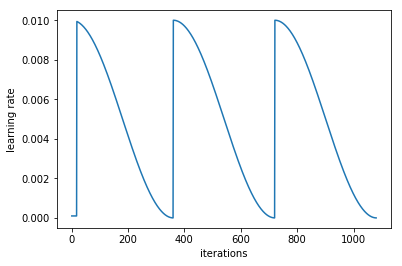

In [43]:
learn.sched.plot_lr()

validation loss isn't improving much, so there's probably no point further training the last layer on its own.

since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [44]:
learn.save('224_lastlayer')

In [45]:
learn.load('224_lastlayer')

### Fine-tuning and differential learning rate annealing

now that we have a good final layer trained, we can try fine-tuning the other layers. to tell the learner that we want to unfreeze the remaining layers, just call unfreeze().

In [46]:
learn.unfreeze()

note that the other layers have _already_ been trained to recognize imagenet photos, so we want to be careful of not destroying the carefully tuned weights that are already there.

generally, the earlier layers have more general-purpose features. we would expect them to need less fine-tuning for new datasets. for this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2. we refer to the application of varying learning rates as _differential learning rates_.

In [47]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [48]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.06259  0.02368  0.99121]                         
[ 1.       0.03947  0.02103  0.99219]                         
[ 2.       0.02892  0.01972  0.99219]                         
[ 3.       0.03153  0.01923  0.99219]                         
[ 4.       0.02391  0.01744  0.99316]                         
[ 5.       0.02334  0.01835  0.99219]                         
[ 6.       0.02384  0.01825  0.99023]                         



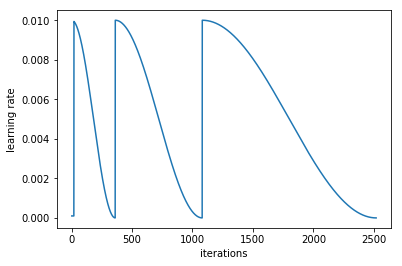

In [49]:
learn.sched.plot_lr()

what's being plotted is the learning rate fo the _final layers_. the learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested.

In [50]:
learn.save('224_all')

In [51]:
learn.load('224_all')

there is something else we can do with data augmentation: use it at _inference_ time (also known as _test_ time). not surprisingly, this is known as _test time augmentation_, or just TTA.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). it then takes the average prediction from these images, and uses that. to use TTA on the validation set, we can use the learner's TTA() method.

In [52]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)

In [53]:
accuracy_np(probs, y)

NameError: name 'accuracy_np' is not defined

i generally see a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique.

# Analyzing results

## Confusion matrix

In [54]:
preds = np.argmax(probs, axis=1)
probs = probs[:, 1]

a common way to analyze the result of a classification model is to use a confusion matrix.

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[992   8]
 [  4 996]]


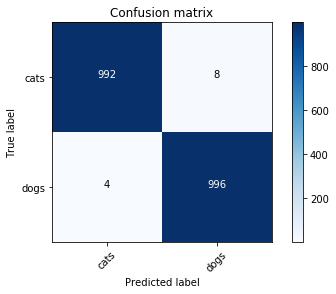

In [56]:
plot_confusion_matrix(cm, data.classes)

## Looking at pictures again

Most incorrect cats


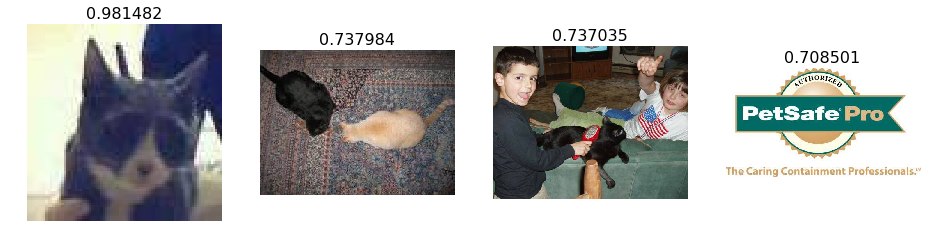

In [57]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


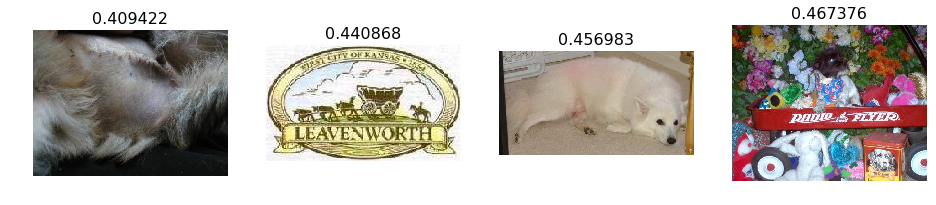

In [58]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

## Review: steps to train a world-class image classifier

1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train lasy layer with data augmentation (ie, precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting

## Understanding the code for our first model

let's look at the dogs v cats code line by line

**tfms** stands for _transformations_. tfms_from_model takes care of resizing, image cropping, initial normalization (creating data with (mean, stdev) of (0, 1)), and more.

In [59]:
tfms = tfms_from_model(resnet34, sz)

we need a path that points to the dataset. in this path we will also store temporary data and final results. ImageClassifierData.from_paths reads data from a provided path and creates a dataset ready for training.

In [60]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

ConvLearner.pretrained builds _learner_ that contains a pre-trained model. the last layer of the model needs to be replaced with the layer of the right dimensions. the pretrained model was trained for 1000 classes therefore the final layer predicts a vector of 1000 probabilities. the model for cats and dogs needs to output a two dimensional vector.

In [61]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

_parameters_ are learned by fitting a model to the data. _hyperparameters_ are another kind of parameter that cannot be directly learned from the regular training process. these parameters express "higher-level" properties of the model such as its complexity of how fast it should learn. two examples of hyperparameters are the _learning rate_ and the _number of epochs_.

during the iterative training of a neural network, a _batch_ or _mini-batch_ is a subset of training samples used in one iteration of stochastic gradient descent (SGD). an _epoch_ is a single pass through the entire training set which consists of multiple iterations of SGD.

we can now _fit_ the model; that is, use _gradient descent_ to find the best parameters for the fully connected layer we added, that can separate cat pictures from dog pictures. we need to pass two hyperparameters: the _learning rate_ (generally 1e-2 or 1e-3 is a good starting point, we'll look more at this next) and the _number of epochs_ (you can pass in a higher number and just stop training when you see it's no longer improving, then re-run it with the numnber of epochs you found works well).

In [62]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.05347  0.02359  0.99121]                         



## Analyzing results: loss and accuracy

when we run learn.fit we print 3 performance values. these are the value of the **loss** in the training set, the value of the loss in the validation set, and the validation accuracy.

**accuracy** is the ratio of correct prediction to the total number of predictions. the **loss** function is representing the price paid for inaccuracy of predictions.

the loss associated with one example in binary classification is given by: -(y * log(p) + (1 - y) * log(1 - p)) where y is the true label of x and p is the probability predicted by our model that the label is 1.

In [63]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1 - y) * np.log(1 - p)))

In [64]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

note that in our toy example above our accuracy is 100% and our loss is 0.16. compare that to a loss of 0.03 that we are getting while predicting cats and dogs. binary classification loss is an easier function to optimize than accuracy.